In [1]:
## # https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpxpy

In [2]:
sns.set(rc={'figure.figsize':(12, 12)})

In [3]:
fname = 'hill_10km_2_5_2021.gpx'
gpx_file = open(fname, 'r')
gpx = gpxpy.parse(gpx_file)

In [4]:
print(len(gpx.tracks))
print(len(gpx.tracks[0].segments))
print(len(gpx.tracks[0].segments[0].points))

1
1
1783


In [5]:
run_data = gpx.tracks[0].segments[0].points

In [6]:
temp = []
for pt in run_data:
    temp.append([pt.latitude, pt.longitude, pt.elevation, pt.time])
df = pd.DataFrame(temp, columns=['lat', 'lon', 'alt', 'time'])

In [7]:
display(df.head())
display(df.dtypes)

,lat,lon,alt,time
0,52.208985,0.105034,11.9,2021-05-02 09:20:22+00:00
1,52.209028,0.104891,11.8,2021-05-02 09:20:24+00:00
2,52.209058,0.104737,11.7,2021-05-02 09:20:26+00:00
3,52.209080,0.104578,11.6,2021-05-02 09:20:28+00:00
4,52.209097,0.104419,11.5,2021-05-02 09:20:30+00:00


lat                           float64
lon                           float64
alt                           float64
time    datetime64[ns, SimpleTZ("Z")]
dtype: object

In [8]:
print(df['time'].head())
df['time'] = df['time'].dt.tz_localize(None)
#df['time'] = df['time'] - df['time'][0]
print(df['time'].head())
df = df.set_index('time')

0   2021-05-02 09:20:22+00:00
1   2021-05-02 09:20:24+00:00
2   2021-05-02 09:20:26+00:00
3   2021-05-02 09:20:28+00:00
4   2021-05-02 09:20:30+00:00
Name: time, dtype: datetime64[ns, SimpleTZ("Z")]
0   2021-05-02 09:20:22
1   2021-05-02 09:20:24
2   2021-05-02 09:20:26
3   2021-05-02 09:20:28
4   2021-05-02 09:20:30
Name: time, dtype: datetime64[ns]


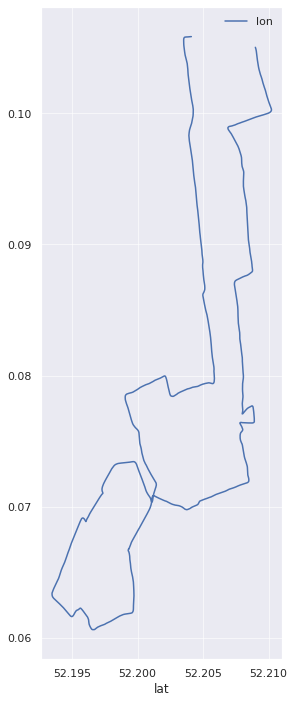

In [9]:
ax = df.plot(x='lat', y='lon')
ax.set_aspect('equal')
plt.show()

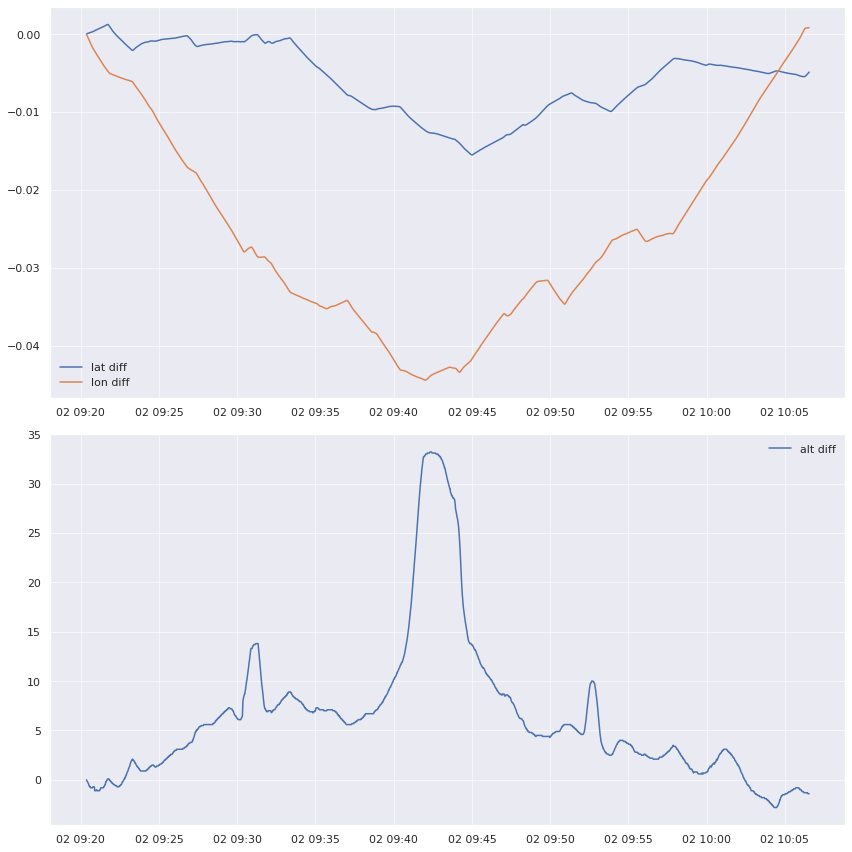

In [10]:
fig, axs = plt.subplots(2, 1, figsize = (12, 12))
axs[0].plot(df['lat']-df['lat'][0], label='lat diff')
axs[0].plot(df['lon']-df['lon'][0], label='lon diff')
axs[1].plot(df['alt']-df['alt'][0], label='alt diff')
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()

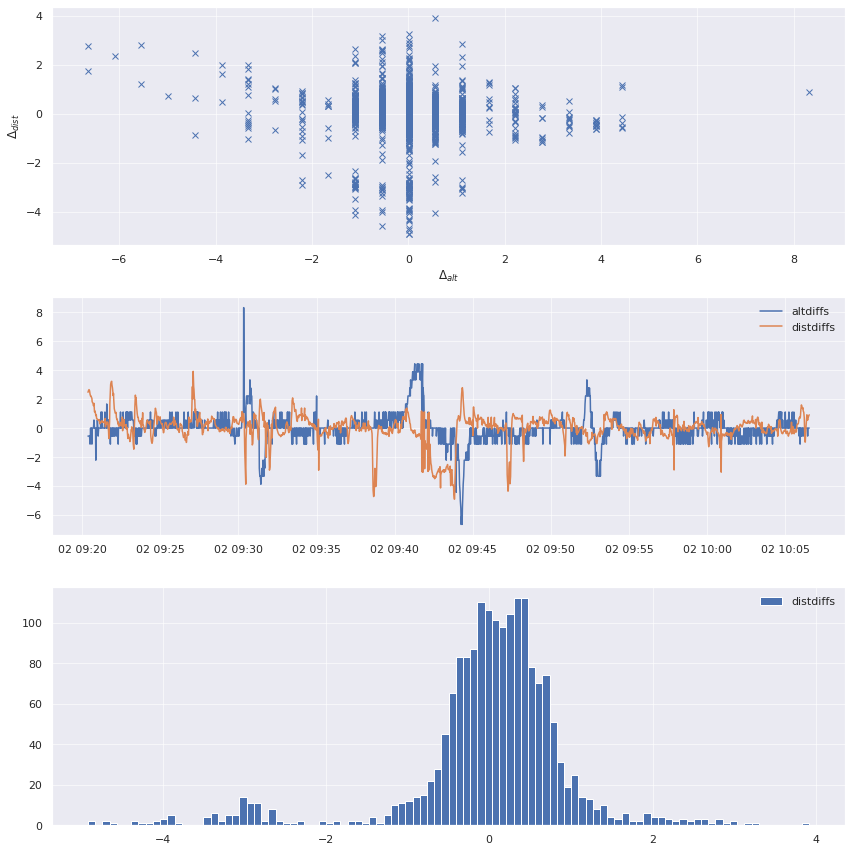

In [30]:
xpos = np.array(df['lon']*111.320*np.cos(df['lat']*np.pi/180.))
ypos = np.array(df['lat']*110.574)
xdiffs = np.diff(xpos)*1000
ydiffs = np.diff(ypos)*1000
timediffs = np.diff(np.array(df.index, dtype=np.float64))/1e9
dists = np.sqrt(xdiffs**2 + ydiffs**2)/timediffs
altdiffs = np.diff(np.array(df['alt']))/timediffs

fig, axs = plt.subplots(3, 1, figsize = (12, 12))
#axs = [axs]
altdiffs_adj = (altdiffs-np.mean(altdiffs))/np.std(altdiffs)
dists_adj = (dists-np.mean(dists))/np.std(dists)
axs[0].plot(altdiffs_adj, dists_adj, 'x', label=r'$\Delta$')
#axs[0].legend()
axs[0].set_xlabel(r'$\Delta_{alt}$')
axs[0].set_ylabel(r'$\Delta_{dist}$')
axs[1].plot(df.index[:-1], altdiffs_adj, label='altdiffs')
axs[1].plot(df.index[:-1], dists_adj, label='distdiffs')
axs[1].legend()
bins = 100#np.arange(-6, 6, 12*10)
#axs[2].hist(altdiffs_adj, label='altdiffs', bins=bins)
axs[2].hist(dists_adj, label='distdiffs', bins=bins)
axs[2].legend()
plt.tight_layout()
plt.show()

- Defining speed:
   * Total distance travelled in a minute.
   * Derivative of smoothed distance function.

Does my speed correlate with height change?

- Defining $\Delta_{alt}$:
   - Total alt change in a minute.
   - Derivative of smoothed function.


Check all four combinations. Lag?

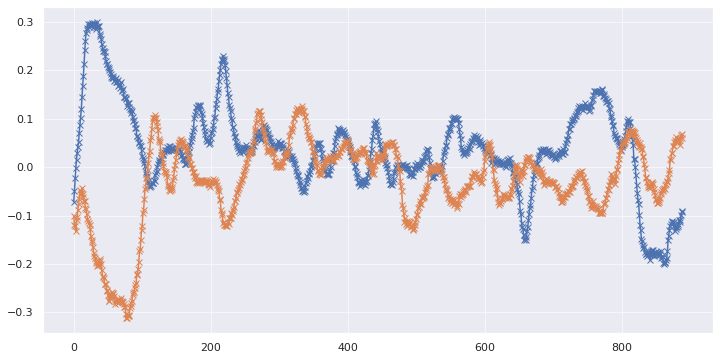

In [55]:
## # Should be resampled! Time intervals still not constant.
fig = plt.figure(figsize=(12, 6))
offset_corrs1 = []
for ind in range(1, len(altdiffs_adj)//2):
    temp_x = altdiffs_adj[ind:]
    temp_y = dists_adj[:-ind]
    offset_corrs1.append( np.corrcoef(temp_x, temp_y)[0, 1] )
offset_corrs2 = []
for ind in range(1, len(altdiffs_adj)//2):
    temp_x = altdiffs_adj[:-ind]
    temp_y = dists_adj[ind:]
    offset_corrs2.append( np.corrcoef(temp_x, temp_y)[0, 1] )
plt.plot(offset_corrs1, 'x-')
plt.plot(offset_corrs2, 'x-')
plt.show()